## Imports and set data path

In [1]:
# Imports
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set options
pd.set_option('display.max_columns',None)

# Set data path here
data_path = 'airfoil_2k_data.h5'


## Explore contents and architecture of .h5 data file

`Data Structure` <br>
The .h5 data file is structured as follows: <br>

|-- root (group, 1831 members) <br>
 &emsp;&emsp;	|-- XXXX (group, 3 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- landmarks (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- trans_model (group, 2 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- turb_model (group, 2 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- 'Re003000000' (group, 2 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- 'Re006000000' (group, 2 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- 'Re009000000' (group, 2 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	&emsp;&emsp;	|-- trans_model (group, 2 members) <br>
 
 
 
 
 
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	|-- alpha12 (group, 500 members) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_d (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_l (dataset) <br>
 &emsp;&emsp;	 &emsp;&emsp;	 &emsp;&emsp;	|-- C_m (dataset) <br>



In [8]:
# Open file and print the top level group names/keys

# This data set contains 8997 unique airfoil shapes.
with h5py.File(data_path, 'r') as hf:
    af_names = [k for k in hf.keys()]
    print(af_names[:25], '...')

    
    print([k for k in hf[af_names[0]]['turb_model']['Re009000000']])

['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024'] ...
['alpha+00', 'alpha+01', 'alpha+02', 'alpha+03', 'alpha+04', 'alpha+05', 'alpha+06', 'alpha+07', 'alpha+08', 'alpha+09', 'alpha+10', 'alpha+11', 'alpha+12', 'alpha+13', 'alpha+14', 'alpha+15', 'alpha+16', 'alpha+17', 'alpha+18', 'alpha+19', 'alpha+20', 'alpha-01', 'alpha-02', 'alpha-03', 'alpha-04']


In [3]:
# Explore contents of LayoutXXX groups (first 3)

# Each XXXX airfoil group contains 3 members: 2 groups and 1 dataset.
# The dataset "landmarks" is a (1001, 2) NumPy array contain (x, y) landmarks describing the airfoil shape.
# The two groups contain aerodynamic flow quantities (lift, drag, and moment coefficients) computed at
# two angles of attack: alpha = 4 and alpha = 12 degrees.
with h5py.File(data_path, 'r') as hf:
    for name in af_names[0:3]:
        print('-------------------------------------------------')
        print('Group Name:', name)
        print('Group Info:', hf[name])
        print('')
        
        print('Group Members:\n')
        for key in list(hf[name].keys()):
            print(key)
            if 'alpha' in key:
                for key_aero in list(hf[name][key].keys()):
                    print('Aerodynamic quantities:')
                    print(hf[name][key][key_aero], '=', hf[name][key][key_aero][()])
            else:
                print('Airfoil shape data:')
                print(hf[name][key])
            print('')
    print('-------------------------------------------------')
    

-------------------------------------------------
Group Name: 0000
Group Info: <HDF5 group "/0000" (3 members)>

Group Members:

landmarks
Airfoil shape data:
<HDF5 dataset "landmarks": shape (1001, 2), type "<f8">

trans_model
Airfoil shape data:
<HDF5 group "/0000/trans_model" (3 members)>

turb_model
Airfoil shape data:
<HDF5 group "/0000/turb_model" (3 members)>

-------------------------------------------------
Group Name: 0001
Group Info: <HDF5 group "/0001" (3 members)>

Group Members:

landmarks
Airfoil shape data:
<HDF5 dataset "landmarks": shape (1001, 2), type "<f8">

trans_model
Airfoil shape data:
<HDF5 group "/0001/trans_model" (3 members)>

turb_model
Airfoil shape data:
<HDF5 group "/0001/turb_model" (3 members)>

-------------------------------------------------
Group Name: 0002
Group Info: <HDF5 group "/0002" (3 members)>

Group Members:

landmarks
Airfoil shape data:
<HDF5 dataset "landmarks": shape (1001, 2), type "<f8">

trans_model
Airfoil shape data:
<HDF5 group 

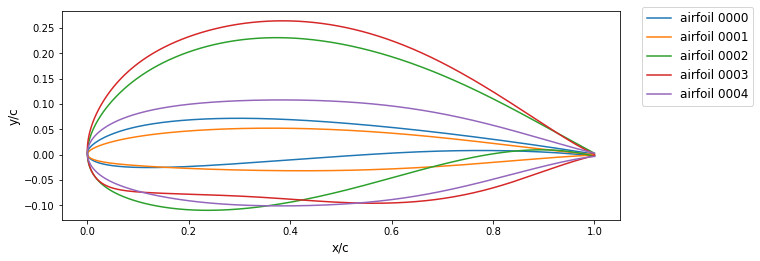

In [4]:
plt.figure(figsize=(10, 6))
with h5py.File(data_path, 'r') as hf:
    for name in af_names[:5]:
        landmarks = hf[name]['landmarks'][()]
        plt.plot(landmarks[:, 0], landmarks[:, 1], label='airfoil {}'.format(name))
plt.xlabel('x/c', fontsize=12)
plt.ylabel('y/c', fontsize=12)
plt.gca().set_aspect(1.)
plt.legend(bbox_to_anchor=(1.25, 1.05), fontsize=12)
plt.show()

In [5]:

cl_alpha04, cd_alpha04, cm_alpha04 = [], [], []
cl_alpha12, cd_alpha12, cm_alpha12 = [], [], []
with h5py.File(data_path, 'r') as hf:
    for name in af_names:
        cl_alpha04.append(hf[name]['alpha04']['C_l'][()])
        cd_alpha04.append(hf[name]['alpha04']['C_d'][()])
        cm_alpha04.append(hf[name]['alpha04']['C_m'][()])
        
        cl_alpha12.append(hf[name]['alpha12']['C_l'][()])
        cd_alpha12.append(hf[name]['alpha12']['C_d'][()])
        cm_alpha12.append(hf[name]['alpha12']['C_m'][()])

plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.violinplot([cl_alpha04, cl_alpha12])
plt.xticks([1, 2], labels=['4', '12'])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Lift')

plt.subplot(132)
plt.violinplot([cd_alpha04, cd_alpha12])
plt.xticks([1, 2], labels=['4', '12'])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Drag')

plt.subplot(133)
plt.violinplot([cm_alpha04, cm_alpha12])
plt.xticks([1, 2], labels=['4', '12'])
plt.xlabel('Angle of Attack (deg.)')
plt.ylabel('Coefficient of Momentum')

plt.show()

KeyError: "Unable to open object (object 'alpha04' doesn't exist)"